In [22]:
import torch
from torchvision import transforms
from torchvision import datasets, transforms

data_dir = 'CroppedYale'
batch_size = 30

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((192, 168)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # randomly flip image horizontally
  ])

train_data = datasets.ImageFolder(data_dir + '/train', transform=transform)
val_data = datasets.ImageFolder(data_dir + '/val', transform=transform)
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [12]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([30, 1, 192, 168])
torch.Size([30])


In [23]:
# visualize a batch of training data
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

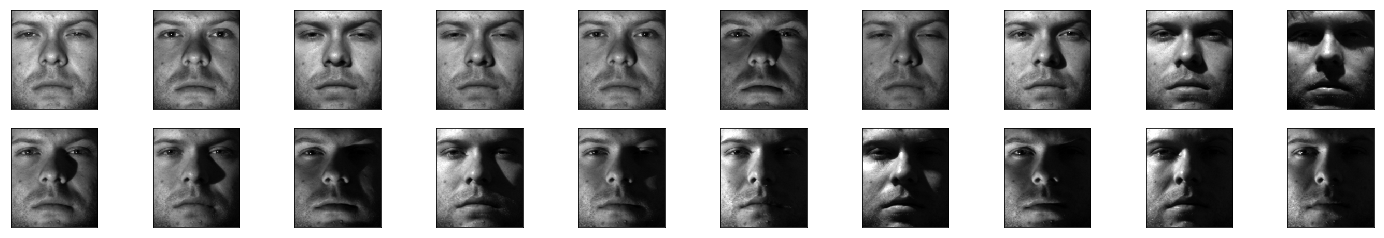

In [24]:
import numpy as np
# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

##  Simple Linear Layers

In [13]:
from torch import nn
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(32256, 700)
        self.fc2 = nn.Linear(700, 256)
        # Output layer, 40 units
        self.fc3 = nn.Linear(256, 40)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of the operations
        x = x.view(x.shape[0], -1)
        
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        x = self.fc3(x)
        x = self.softmax(x)
        
        return x

In [14]:
model = Network()
model = model.cuda()

In [15]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

epochs = 4000
steps = 0

train_losses, test_losses, val_losses = [], [], []
for e in range(epochs):
    running_loss = 0
    train_accuracy = 0
    for images, labels in trainloader:
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        val_loss = 0
        test_accuracy = 0
        val_accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                if train_on_gpu:
                    images, labels = images.cuda(), labels.cuda()
        
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_accuracy += torch.mean(equals.type(torch.FloatTensor))
                
            for images, labels in valloader:
                if train_on_gpu:
                    images, labels = images.cuda(), labels.cuda()
                log_ps = model(images)
                val_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                val_accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        val_losses.append(val_loss/len(valloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Training Accuracy: {:.3f}.. ".format(train_accuracy/len(trainloader)),
              "Validation Loss: {:.3f}.. ".format(val_loss/len(valloader)),
              "Validation Accuracy: {:.3f}".format(val_accuracy/len(valloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(test_accuracy/len(testloader)))
        
        # Save train results to train_linear_layers.txt
        with open('train_linear_layers.txt', "a") as file:
            file.write("Epoch: {}/{}.. ".format(e+1, epochs) + ' ' +
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)) + ' ' + 
              "Training Accuracy: {:.3f}.. ".format(train_accuracy/len(trainloader)) + ' ' +
              "Validation Loss: {:.3f}.. ".format(val_loss/len(valloader)) + ' ' +
              "Validation Accuracy: {:.3f}".format(val_accuracy/len(valloader)) + ' ' +
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)) + ' ' +
              "Test Accuracy: {:.3f}".format(test_accuracy/len(testloader)) + '\n') 

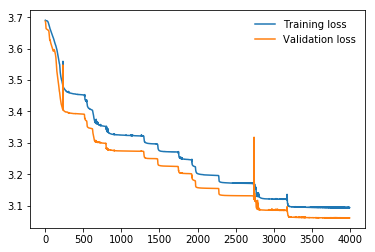

In [20]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

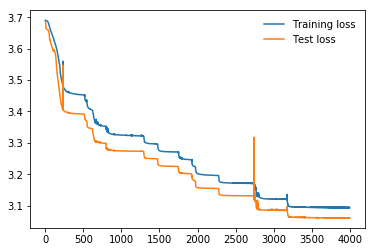

In [21]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Test loss')
plt.legend(frameon=False)